<a href="https://colab.research.google.com/github/AbdulmagedALKHULAIFI/Automatic-classifer-consumer-goods/blob/main/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

# Contexte

L'objectif de ce projet est d'aider l’entreprise "Place de marché” dans l'amélioration de l'expérience des utilisateurs de leur plateforme et rend plus fluide et agréable. Commençant par l'automatisation de la catégorisation des articles chargés par les vendeurs.

## Missions

Les missions qui me sont confiées ce sont: 



*    réaliser une première étude de faisabilité d'un moteur de classification en se basant sur l'image et la description de produit
*   Prétaiter le jeu de données 
*   Réduire les dimension de jeu de données
*   Regrouper les produits ayant des carateristiques simlaires





In [221]:
!pip install -U gensim

In [222]:
!pip install yellowbrick

In [223]:
!pip install bert-for-tf2

In [224]:
!pip install tensorflow

In [225]:
pip install tensorflow-text

# To-do list

- corriger l'affichage des mots le plus communs dans un cluster
- Commenter le code et expliquer les notations techniques comme le sillouhaite score
- Envistiger sur le bag of words

# Import

In [226]:
# import libraries
import numpy as np 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import ngrams
from nltk import bigrams
from nltk import trigrams
import  collections
import gensim
from gensim.models import Word2Vec
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies

import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text




In [227]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [228]:
data = pd.read_csv("./flipkart_com-ecommerce_sample_1050.csv")
data.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


Le jeu de données est composé de deux partie:

* Jeu de données de produits de site sous format CSV
* Un répertoire contenant les images de produits

In [229]:
data.describe()

,retail_price,discounted_price
count,1049.000000,1049.000000
mean,2186.197331,1584.527169
std,7639.229411,7475.099680
min,35.000000,35.000000
25%,555.000000,340.000000
50%,999.000000,600.000000
75%,1999.000000,1199.000000
max,201000.000000,201000.000000


In [230]:
corpus = data[['description']]
corpus.head(3)

,description
0,Key Features of Elegance Polyester Multicolor ...
1,Specifications of Sathiyas Cotton Bath Towel (...
2,Key Features of Eurospa Cotton Terry Face Towe...


In [231]:
corpus.shape

(1050, 1)

#  Récupération des catégories principales

In [232]:
data['main_cat'] = data.product_category_tree.str.split(">>",expand=True,)[0]
data.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,main_cat
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...","[""Home Furnishing"
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...","[""Baby Care"
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...","[""Baby Care"


In [233]:
data['main_cat'] = data['main_cat'].str.replace(r'"', '')
data['main_cat'] = data['main_cat'].str.replace(r'[', '')
data['main_cat'] = data['main_cat'].str.replace(r']', '')

In [234]:
data['main_cat'].unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

# Data preprocessing

In [235]:
dataMini = data[['main_cat','description']]
dataMini

,main_cat,description
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...
3,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...
...,...,...
1045,Baby Care,Oren Empower Extra Large Self Adhesive Sticker...
1046,Baby Care,Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047,Baby Care,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048,Baby Care,Buy Wallmantra Medium Vinyl Sticker Sticker fo...


In [236]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [237]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [238]:
dataMini["text_clean"] = dataMini["description"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dataMini.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,main_cat,description,text_clean
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,key feature elegance polyester multicolor abst...
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,specification sathiyas cotton bath towel 3 bat...
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,key feature eurospa cotton terry face towel se...
3,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...,key feature santosh royal fashion cotton print...
4,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...,key feature jaipur print cotton floral king si...


Créer une list de texte nettoyé pour entrainer les modèles non-supervisé

In [239]:
clean_desc = []
for w in range(len(dataMini.text_clean)):
    clean_desc.append(dataMini.text_clean.iloc[w])

In [240]:
clean_desc[:3]

['key feature elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain 213 cm height pack 2 price r 899 curtain enhances look interiorsthis curtain made 100 high quality polyester fabricit feature eyelet style stitch metal ringit make room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant apparancegive home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlightspecifications elegance polyester multicolor abstract eyelet door curtain 213 cm height pack 2 general brand elegance designed door type eyelet model name abstract polyester door curtain set 2 model id duster25 color multicolor di

Ici, nous convertirons les catégories des produits de format text en format numérique pour que Bert puisse l'utiliser

In [241]:
# dataMini["main_cat_num"] = dataMini["main_cat"].astype('category').cat.codes

In [242]:
dataMini.sample(10)

,main_cat,description,text_clean
386,Beauty and Personal Care,Flipkart.com: Buy French Factor Man of the Yea...,flipkartcom buy french factor man year deodora...
122,Computers,Key Features of Shopizone BMW Wheel 32 GB Pen...,key feature shopizone bmw wheel 32 gb pen driv...
917,Home Decor & Festive Needs,Megaway 196.85 inch White Rice Lights (Pack of...,megaway 19685 inch white rice light pack 5 pri...
165,Kitchen & Dining,Rockmantra Cute Two Cats Ceramic Mug (5.5 l)\r...,rockmantra cute two cat ceramic mug 55 l price...
492,Computers,Buy Rega IT Hp Pavilion DV6170EA DV6171CL 12 C...,buy rega hp pavilion dv6170ea dv6171cl 12 cell...
913,Watches,Specifications of Like Analog Purple Clock Fun...,specification like analog purple clock functio...
488,Computers,Buy Rega IT Hp Pavilion DV6-6080SF DV6-6081EI ...,buy rega hp pavilion dv66080sf dv66081ei 12 ce...
1017,Home Furnishing,Key Features of Aroma Comfort Polyester Cream ...,key feature aroma comfort polyester cream self...
1015,Computers,Key Features of PRINT SHAPES red Heart Laptop ...,key feature print shape red heart laptop skin ...
162,Kitchen & Dining,Prithish Believe In Yourself Double Color Cera...,prithish believe double color ceramic mug 330 ...


## Division de jeu de données

Nous allons diviser le jeu de données en deux parties(train et test) pour entraîner les modèles machine learning supervisés

In [243]:
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.model_selection import train_test_split

## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dataMini, test_size=0.2)

# X_train, X_test, y_train, y_test = train_test_split(dataMini['description'],dataMini['main_cat_num'], test_size=0.2)

# get target
y_train = dtf_train["main_cat"].values
y_test = dtf_test["main_cat"].values

# N-gram

N-gramme est une sous-séquence de n éléments construite à partir d'une séquence donnée. L'idée est que, à partir d'une séquence de mots donnée. il est possible d'obtenir la fonction de vraisemblance de l'apparition de mot suivant.

In [244]:
# generate unigrams bigrams trigrams

unigram=[]
bigram=[]
trigram=[]
tokenized_text=[]

for sentence in dataMini['text_clean']:
    unigram.extend(unigram)
    bigram.extend(bigrams(sentence.split(' ')))
    trigram.extend(trigrams(sentence.split(' ')))

In [245]:
bigramFreq = collections.Counter(bigram)
bigramFreq

Counter({('key', 'feature'): 207,
         ('feature', 'elegance'): 1,
         ('elegance', 'polyester'): 2,
         ('polyester', 'multicolor'): 4,
         ('multicolor', 'abstract'): 3,
         ('abstract', 'eyelet'): 4,
         ('eyelet', 'door'): 14,
         ('door', 'curtain'): 26,
         ('curtain', 'floral'): 1,
         ('floral', 'curtainelegance'): 1,
         ('curtainelegance', 'polyester'): 1,
         ('curtain', '213'): 4,
         ('213', 'cm'): 9,
         ('cm', 'height'): 22,
         ('height', 'pack'): 12,
         ('pack', '2'): 61,
         ('2', 'price'): 15,
         ('price', 'r'): 342,
         ('r', '899'): 5,
         ('899', 'curtain'): 1,
         ('curtain', 'enhances'): 1,
         ('enhances', 'look'): 1,
         ('look', 'interiorsthis'): 1,
         ('interiorsthis', 'curtain'): 1,
         ('curtain', 'made'): 1,
         ('made', '100'): 8,
         ('100', 'high'): 2,
         ('high', 'quality'): 69,
         ('quality', 'polyester'): 3,

In [246]:
trigramFreq = collections.Counter(trigram)
trigramFreq

Counter({('key', 'feature', 'elegance'): 1,
         ('feature', 'elegance', 'polyester'): 1,
         ('elegance', 'polyester', 'multicolor'): 2,
         ('polyester', 'multicolor', 'abstract'): 3,
         ('multicolor', 'abstract', 'eyelet'): 3,
         ('abstract', 'eyelet', 'door'): 3,
         ('eyelet', 'door', 'curtain'): 14,
         ('door', 'curtain', 'floral'): 1,
         ('curtain', 'floral', 'curtainelegance'): 1,
         ('floral', 'curtainelegance', 'polyester'): 1,
         ('curtainelegance', 'polyester', 'multicolor'): 1,
         ('door', 'curtain', '213'): 4,
         ('curtain', '213', 'cm'): 4,
         ('213', 'cm', 'height'): 4,
         ('cm', 'height', 'pack'): 12,
         ('height', 'pack', '2'): 7,
         ('pack', '2', 'price'): 11,
         ('2', 'price', 'r'): 15,
         ('price', 'r', '899'): 5,
         ('r', '899', 'curtain'): 1,
         ('899', 'curtain', 'enhances'): 1,
         ('curtain', 'enhances', 'look'): 1,
         ('enhances', 'loo

# Features extraction

Les données texte ne sont pas calculables et doivent donc être transformées en données numériques comme matrices ou des vecteurs pour que les modèles machine learning pussient les utilisent.

## TF-IDF

TF-IDF(Term Frequency/Inverse Document Frequency) est l'une des techniques  les plus populaires pour analyser l'importance d'un mot dans un document.

In [247]:
tf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3))

## bag of words

Le sac de mots est un modèle de représentation des données textuels, qui compte simplement combien de fois un mot apparaît dans un document.

In [248]:
## Count (classic BoW)
bow_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,3))

## Universal sentenance encoder


In [249]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
USE_embed = hub.KerasLayer(module_url, trainable=False, name='USE_embedding')

In [250]:
train_embeddings = USE_embed(dataMini.description)['outputs'].numpy()
# train_embeddings = USE_embed(dataMini.text_clean)['outputs'].numpy()


kmeans = KMeans(n_clusters=7, random_state=42).fit(train_embeddings)
dataMini.loc[:,'use_cluster'] = None
dataMini.loc[:,'use_cluster'] = kmeans.labels_

display(dataMini.sort_values(by = 'main_cat'))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,main_cat,description,text_clean,use_cluster
1049,Baby Care,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...,buy uberlyfe large vinyl sticker rs595 online ...,5
613,Baby Care,Specifications of Piyo Piyo Four Stage Waterpr...,specification piyo piyo four stage waterproof ...,1
612,Baby Care,Specifications of Cheeky Chompers The Neckerch...,specification cheeky chompers neckerchew simpl...,1
977,Baby Care,Key Features of FS Mini Klub Baby Girl's Bodys...,key feature f mini klub baby girl bodysuit fab...,1
975,Baby Care,Key Features of Jacadi paris Baby Boy's Stripe...,key feature jacadi paris baby boy striped casu...,1
...,...,...,...,...
523,Watches,Maxima 09321CMGY Gold Analog Watch - For Men ...,maximum 09321cmgy gold analog watch men buy ma...,3
522,Watches,Maxima 24742LMGY Gold Analog Watch - For Men ...,maximum 24742lmgy gold analog watch men buy ma...,3
521,Watches,Maxima 20981LMGI Attivo Analog Watch - For Me...,maximum 20981lmgi attivo analog watch men buy ...,3
548,Watches,Timewel 1100-N145 Analog Watch - For Men - Bu...,timewel 1100n145 analog watch men buy timewel ...,3


## Doc2vect

In [251]:
tokenized_sent = []
for s in dataMini['text_clean']:
    tokenized_sent.append(word_tokenize(s.lower()))


from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]


model = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)

'''
vector_size = Dimensionality of the feature vectors.
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
alpha = The initial learning rate.
'''

## Print model vocabulary
words = list(model.wv.index_to_key)



test_doc = word_tokenize("I had pizza and pasta".lower())
test_doc_vector = model.infer_vector(test_doc)
model.docvecs.most_similar(positive = [test_doc_vector])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).


[(199, 0.8081302046775818),
 (235, 0.8007767200469971),
 (223, 0.7884155511856079),
 (216, 0.7875153422355652),
 (218, 0.7871080040931702),
 (215, 0.7783594131469727),
 (890, 0.7704285979270935),
 (880, 0.755469799041748),
 (176, 0.7500585913658142),
 (182, 0.7477453947067261)]

# Create train corpus

In [252]:
def createInput(vectorizer):
    corpus = dtf_train["text_clean"]
    vectorizer.fit(corpus)
    X_train = vectorizer.transform(corpus)
    return X_train

# Classifieurs

In [253]:
navie_bayes_classifier = naive_bayes.MultinomialNB()

In [254]:
kmeans = KMeans(n_clusters = 7, n_init = 17, n_jobs = -1, tol = 0.01, max_iter = 200)
def cluster_kmeans(vect):

    kmeans.fit(vect)
    #this loop transforms the numbers back into words
    common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
#     for num, centroid in enumerate(common_words):
#         print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))
    # print(enumerate(common_words))
    

# Pipeline

## Modèles supervisés

In [255]:
def createPipeline(classifier,vectorizer):
    ## pipeline
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## Create X_train 
    X_train = createInput(vectorizer)
    
    ## train classifier
    model["classifier"].fit(X_train, y_train)
    
    ## test
    X_test = dtf_test["text_clean"].values
    predicted = model.predict(X_test)
    return predicted

Nous allons créer des pipeline pour tous les extracteur de features :

In [256]:
tf_predicted = createPipeline(navie_bayes_classifier,tf_vectorizer)

In [257]:
bow_predicted = createPipeline(navie_bayes_classifier,bow_vectorizer)

## Modèles non-supervisés

In [258]:
def pipeline_non_supervise(feature_extractor,extractor_name,data):
  ''' extractor_name : the given name to the new predicted column values in the dataset "data"
  return sillhouette score for the evaluation of the model
  ''' 
  extractor = feature_extractor.fit_transform(clean_desc)
  cluster_kmeans(extractor)
  data[extractor_name] = kmeans.labels_


In [259]:
pipeline_non_supervise(tf_vectorizer,'cluster_tfidf_kmeans',dataMini)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [260]:
dataMini.head(3)

,main_cat,description,text_clean,use_cluster,cluster_tfidf_kmeans
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,key feature elegance polyester multicolor abst...,2,5
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,specification sathiyas cotton bath towel 3 bat...,1,5
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,key feature eurospa cotton terry face towel se...,2,5


In [261]:
pipeline_non_supervise(bow_vectorizer,'cluster_bow_kmeans',dataMini)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [262]:
dataMini.head(3)

,main_cat,description,text_clean,use_cluster,cluster_tfidf_kmeans,cluster_bow_kmeans
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,key feature elegance polyester multicolor abst...,2,5,5
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,specification sathiyas cotton bath towel 3 bat...,1,5,5
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,key feature eurospa cotton terry face towel se...,2,5,5


# Evolution de performance

## Matrice de confusion 

### Modèles supervisés

In [263]:
def createConfusionMatrix(predicted):
    classes = np.unique(y_test)

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)
    plt.xticks(rotation=30)

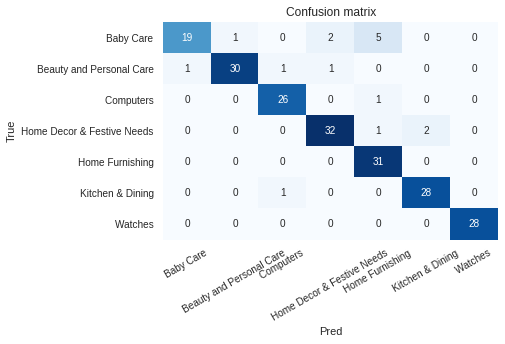

In [264]:
createConfusionMatrix(tf_predicted)

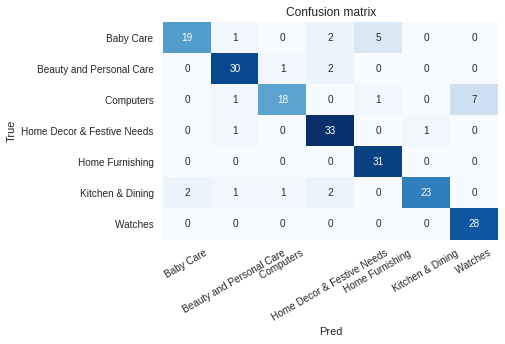

In [265]:
createConfusionMatrix(bow_predicted)

### Modèles non-supervisés

In [266]:
dataReduced = dataMini[['main_cat','use_cluster','cluster_tfidf_kmeans','cluster_bow_kmeans']]
dataReduced

,main_cat,use_cluster,cluster_tfidf_kmeans,cluster_bow_kmeans
0,Home Furnishing,2,5,5
1,Baby Care,1,5,5
2,Baby Care,2,5,5
3,Home Furnishing,1,5,5
4,Home Furnishing,2,5,5
...,...,...,...,...
1045,Baby Care,2,5,5
1046,Baby Care,2,5,5
1047,Baby Care,5,3,2
1048,Baby Care,5,3,2


In [267]:
def create_confiuson_matrix(data, features_extrater):
    
    #Keep only the cluster of the required extrater

    tmp_data = dataReduced[[ 'main_cat',features_extrater]]    
    
    #Handle the categorical features
    dummy = pd.get_dummies(tmp_data['main_cat'])
    
    tmp_data = pd.concat([tmp_data,dummy],axis= 1)
    
    tmp_data.drop('main_cat',axis = 1 , inplace = True)
    
    confusion_matrix = tmp_data.groupby([features_extrater]).sum()
    return confusion_matrix

In [268]:
tfidf_confusin_matrix = create_confiuson_matrix(dataReduced,'cluster_tfidf_kmeans')

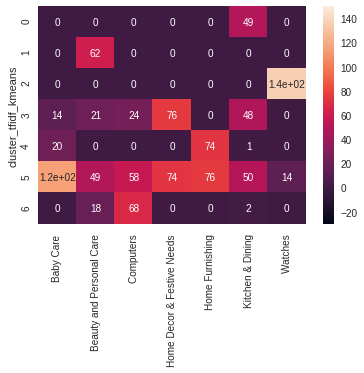

In [269]:
sns.heatmap(tfidf_confusin_matrix, annot=True, vmin=-30, vmax=150)

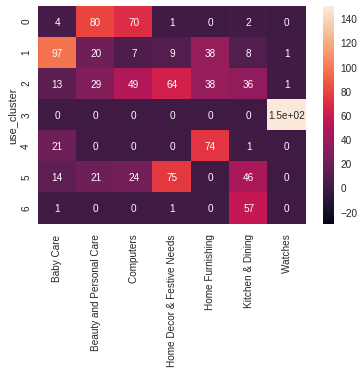

In [270]:
use_confusin_matrix = create_confiuson_matrix(dataReduced,'use_cluster')
sns.heatmap(use_confusin_matrix, annot=True, vmin=-30, vmax=150)

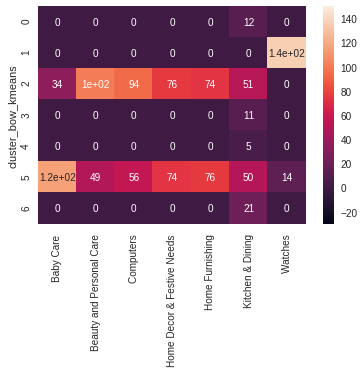

In [271]:
bow_confusin_matrix = create_confiuson_matrix(dataReduced,'cluster_bow_kmeans')
sns.heatmap(bow_confusin_matrix, annot=True, vmin=-30, vmax=150)

Nous allons définir les index des dataframe

In [272]:
tfidf_confusin_matrix['cluster_tfidf_kmeans'] = tfidf_confusin_matrix.index
bow_confusin_matrix['cluster_bow_kmeans'] = bow_confusin_matrix.index
use_confusin_matrix['cluster_use_kmeans'] = use_confusin_matrix.index


tfidf_confusin_matrix.reset_index(drop=True, inplace=True)
bow_confusin_matrix.reset_index(drop=True, inplace=True)
use_confusin_matrix.reset_index(drop=True, inplace=True)


Etiquettage des catégories prédites

Nous récupérons le nom de catégorie le plus prédit pour chaque cluster

**USE**

In [273]:
use_confusin_matrix['predicted_cat_use_kmeans'] = use_confusin_matrix.idxmax(axis=1)
use_confusin_matrix

,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches,cluster_use_kmeans,predicted_cat_use_kmeans
0,4,80,70,1,0,2,0,0,Beauty and Personal Care
1,97,20,7,9,38,8,1,1,Baby Care
2,13,29,49,64,38,36,1,2,Home Decor & Festive Needs
3,0,0,0,0,0,0,148,3,Watches
4,21,0,0,0,74,1,0,4,Home Furnishing
5,14,21,24,75,0,46,0,5,Home Decor & Festive Needs
6,1,0,0,1,0,57,0,6,Kitchen & Dining


 **TF-IDF**

In [274]:
tfidf_confusin_matrix['predicted_cat_tf_kmeans'] = tfidf_confusin_matrix.idxmax(axis=1)
tfidf_confusin_matrix

,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches,cluster_tfidf_kmeans,predicted_cat_tf_kmeans
0,0,0,0,0,0,49,0,0,Kitchen & Dining
1,0,62,0,0,0,0,0,1,Beauty and Personal Care
2,0,0,0,0,0,0,136,2,Watches
3,14,21,24,76,0,48,0,3,Home Decor & Festive Needs
4,20,0,0,0,74,1,0,4,Home Furnishing
5,116,49,58,74,76,50,14,5,Baby Care
6,0,18,68,0,0,2,0,6,Computers


**Bag of words**

In [275]:
bow_confusin_matrix['predicted_cat_bow_kmeans'] = bow_confusin_matrix.idxmax(axis=1)
bow_confusin_matrix

,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches,cluster_bow_kmeans,predicted_cat_bow_kmeans
0,0,0,0,0,0,12,0,0,Kitchen & Dining
1,0,0,0,0,0,0,136,1,Watches
2,34,101,94,76,74,51,0,2,Beauty and Personal Care
3,0,0,0,0,0,11,0,3,Kitchen & Dining
4,0,0,0,0,0,5,0,4,Kitchen & Dining
5,116,49,56,74,76,50,14,5,Baby Care
6,0,0,0,0,0,21,0,6,Kitchen & Dining


## Tableau comparatif

Nous allons créer un tableau comparatif de tous les modèles supervisés et les modèles non-supervisés


In [276]:
Columns = ['Features extractor', 'Classifier', 'score ARI']
comparatif_table = pd.DataFrame(columns = Columns)

In [277]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score

tf_naive_bayes = pd.DataFrame({"Features extractor":["TF-IDF"],
                    "Classifier":["Naive bayes"],
                    "score ARI":[adjusted_rand_score(y_test, tf_predicted)],
                    "Accuracy": [balanced_accuracy_score(y_test,tf_predicted)]})  

In [278]:
bow_naive_bayes = pd.DataFrame({"Features extractor":["Bag of words"],
                    "Classifier":["Naive bayes"],
                    "score ARI":[adjusted_rand_score(y_test, bow_predicted)],
                    "Accuracy": [balanced_accuracy_score(y_test,bow_predicted)]})  

In [279]:
dataReduced = pd.merge(dataReduced,tfidf_confusin_matrix[['cluster_tfidf_kmeans','predicted_cat_tf_kmeans']], how = 'left'
                       ,on = "cluster_tfidf_kmeans")

In [280]:
dataReduced = pd.merge(dataReduced,bow_confusin_matrix[['cluster_bow_kmeans','predicted_cat_bow_kmeans']], how = 'left'
                       ,on = "cluster_bow_kmeans")

In [281]:

dataReduced = pd.merge(dataReduced,use_confusin_matrix[['cluster_use_kmeans','predicted_cat_use_kmeans']], how = 'left'
                       ,right_on = "cluster_use_kmeans",left_on ='use_cluster')
dataReduced = dataReduced.drop(columns=['cluster_use_kmeans'],axis=1)
dataReduced.head(3)

,main_cat,use_cluster,cluster_tfidf_kmeans,cluster_bow_kmeans,predicted_cat_tf_kmeans,predicted_cat_bow_kmeans,predicted_cat_use_kmeans
0,Home Furnishing,2,5,5,Baby Care,Baby Care,Home Decor & Festive Needs
1,Baby Care,1,5,5,Baby Care,Baby Care,Baby Care
2,Baby Care,2,5,5,Baby Care,Baby Care,Home Decor & Festive Needs


In [282]:
tf_kmeans = pd.DataFrame({"Features extractor":["TF-IDF"],
                    "Classifier":["Kmeans"],
                    "score ARI":[adjusted_rand_score(dataReduced['main_cat'],dataReduced['predicted_cat_tf_kmeans'])],
                    "Accuracy": [balanced_accuracy_score(dataReduced['main_cat'],dataReduced['predicted_cat_tf_kmeans'])]})

In [283]:
bow_kmeans = pd.DataFrame({"Features extractor":["Bag of words"],
                    "Classifier":["Kmeans"],
                    "score ARI":[adjusted_rand_score(dataReduced['main_cat'],dataReduced['predicted_cat_bow_kmeans'])],
                    "Accuracy": [balanced_accuracy_score(dataReduced['main_cat'],dataReduced['predicted_cat_bow_kmeans'])]})

In [284]:
use_kmeans = pd.DataFrame({"Features extractor":["USE"],
                    "Classifier":["Kmeans"],
                    "score ARI":[adjusted_rand_score(dataReduced['main_cat'],dataReduced['predicted_cat_use_kmeans'])],
                    "Accuracy": [balanced_accuracy_score(dataReduced['main_cat'],dataReduced['predicted_cat_use_kmeans'])]})


In [285]:
result = comparatif_table.append([tf_kmeans, tf_naive_bayes,bow_naive_bayes,bow_kmeans,use_kmeans])
result

,Features extractor,Classifier,score ARI,Accuracy
0,TF-IDF,Kmeans,0.227402,0.553333
0,TF-IDF,Naive bayes,0.831747,0.922223
0,Bag of words,Naive bayes,0.726764,0.859346
0,Bag of words,Kmeans,0.140817,0.382857
0,USE,Kmeans,0.304949,0.566667


# Sillhouette Score Analysis

In [ ]:
X= tf_vectorizer.fit_transform(dataMini['text_clean'])
X

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

wcss = []

for i in range(2,8):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter= 300, random_state= 42)
    visualizer = SilhouetteVisualizer(kmeans)
    visualizer.fit(X)
    visualizer.show()
    wcss.append(kmeans.inertia_)   

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(kmeans, k=(2,10))
 
visualizer.fit(X)
visualizer.show()   

# T-SNE

In [ ]:
X = createInput(tf_vectorizer)

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y_test)
tsne.show()

In [ ]:
X = createInput(bow_vectorizer)

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y_test)
tsne.show()

# Test 

In [286]:
dataReduced.head(3)

,main_cat,use_cluster,cluster_tfidf_kmeans,cluster_bow_kmeans,predicted_cat_tf_kmeans,predicted_cat_bow_kmeans,predicted_cat_use_kmeans
0,Home Furnishing,2,5,5,Baby Care,Baby Care,Home Decor & Festive Needs
1,Baby Care,1,5,5,Baby Care,Baby Care,Baby Care
2,Baby Care,2,5,5,Baby Care,Baby Care,Home Decor & Festive Needs


In [ ]:
text_use = dataReduced[['main_cat']]

In [ ]:
from sklearn.preprocessing import StandardScaler

# Apply the standard scaler to the TF-IDF features
text_use_std = StandardScaler().fit_transform(text_use)